# Preprocess videos and convert to frames

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Dataset/dataset_22.zip -d /content/dataset/

In [ ]:
!pip install mediapipe

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import csv
import pandas as pd
import os

In [ ]:
coords = mp.solutions.pose
mp_pose = coords.Pose(
    static_image_mode=False,
    model_complexity=2,
    min_detection_confidence=0.5)

In [ ]:
def get_pose_landmarks(video_path):
  cap = cv2.VideoCapture(video_path)
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      break
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = mp_pose.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    try:
      pose = []
      for i, landmark in enumerate(results.pose_landmarks.landmark):
        pose.append([landmark.x, landmark.y, landmark.z])
      pose = np.array([pose])
    except Exception as e:
      print(e)
      pose = None
  return pose

In [ ]:
get_pose_landmarks("/content/dataset/bathroom/bathroom_0.mp4")

array([[[ 0.50973159,  0.35700345, -1.19943976],
        [ 0.53625286,  0.32238114, -1.13308179],
        [ 0.54765129,  0.32420248, -1.13403118],
        [ 0.56549096,  0.32640654, -1.13397062],
        [ 0.49274373,  0.32104447, -1.12720799],
        [ 0.47678059,  0.32102931, -1.12838995],
        [ 0.46413147,  0.32156503, -1.12919569],
        [ 0.58321869,  0.34869817, -0.70742202],
        [ 0.44399089,  0.33647764, -0.67575473],
        [ 0.53609204,  0.39564407, -1.02688062],
        [ 0.4873848 ,  0.38975877, -1.02667606],
        [ 0.69378072,  0.60235518, -0.44843039],
        [ 0.32502443,  0.59490627, -0.34216788],
        [ 0.71280724,  0.89572853, -0.41579691],
        [ 0.29961193,  0.88986856, -0.33621261],
        [ 0.71534908,  1.16921282, -0.80782026],
        [ 0.32356286,  1.10109138, -0.70916986],
        [ 0.73114884,  1.24296117, -0.92389035],
        [ 0.31731319,  1.16867518, -0.8263678 ],
        [ 0.71135449,  1.23862505, -1.01919937],
        [ 0.31187281

Write pose coordinates into file

In [ ]:
import os
import csv
video_dirs = []
output_file = "video_coordinates.csv"
file = open(output_file, "w", newline="")
csv.writer(file).writerow(['Video name', 'Video number', 'Coordinates'])

37

In [ ]:
video_dirs = []
for dir in video_dirs:
  video_dir = "/content/dataset/" + dir
  print("Processing", dir)
  writer = csv.writer(file)
  index = 0
  for filename in os.listdir(video_dir):
    video_path = os.path.join(video_dir, filename)
    pose = get_pose_landmarks(video_path)
    writer.writerow([dir, index, pose])
    print("\t",index)
    index += 1
  print("Coordinates saved successfully")

In [ ]:
# Careful while deleting
import shutil
shutil.rmtree("/content/dataset/dog")

# Read data back from CSV

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Dataset/video_coordinates.csv")

In [ ]:
def string_to_array(string):
    processed_string = string.replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace('\n ', ',').replace('[ ', '[').replace(' ', ',')
    return np.array(eval(processed_string))

In [ ]:
data['coordinates'] = data['coordinates'].apply(lambda x: string_to_array(x))

In [ ]:
data['coordinates'][0].shape

(1, 33, 3)

Prepare data for model

In [ ]:
from keras import Sequential, layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
label_encoder = LabelEncoder()
data['class'] = label_encoder.fit_transform(data['class'])
label_encoder.classes_

array(['I dont know', 'address', 'angry', 'apple', 'bad', 'bathroom',
       'beautiful', 'birds', 'body', 'bowl', 'bread', 'christmas',
       'clock', 'dog', 'door', 'eat', 'expensive', 'family', 'grow',
       'handkerchief'], dtype=object)

In [ ]:
data['class']

0        7
1        7
2        7
3        7
4        7
        ..
1016    17
1017    17
1018    17
1019    17
1020    17
Name: class, Length: 1021, dtype: int64

In [ ]:
X = [seq for seq in data['coordinates']]
Y = data['class'].tolist()

In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
X_train = np.squeeze(X_train, axis=1)

In [ ]:
X_train = pad_sequences(X_train, padding='post', dtype='float32')

Make model

In [ ]:
X_train.shape

(816, 33, 3)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Flatten, Dense, Dropout

model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(33, 3)),
    LSTM(32, return_sequences=True),
    LSTM(32),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(20, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 31, 32)            320       
                                                                 
 lstm_36 (LSTM)              (None, 31, 32)            8320      
                                                                 
 lstm_37 (LSTM)              (None, 32)                8320      
                                                                 
 flatten_18 (Flatten)        (None, 32)                0         
                                                                 
 dense_36 (Dense)            (None, 64)                2112      
                                                                 
 dense_37 (Dense)            (None, 20)                1300      
                                                                 
Total params: 20372 (79.58 KB)
Trainable params: 2037

In [ ]:
X_train.shape

(816, 33, 3)

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
21/21 [==============================] - 5s 72ms/step - loss: 3.0012 - accuracy: 0.0537 - val_loss: 3.0039 - val_accuracy: 0.0244
Epoch 2/50
21/21 [==============================] - 1s 31ms/step - loss: 2.9907 - accuracy: 0.0552 - val_loss: 2.9963 - val_accuracy: 0.0549
Epoch 3/50
21/21 [==============================] - 1s 32ms/step - loss: 2.9681 - accuracy: 0.0752 - val_loss: 2.9472 - val_accuracy: 0.0915
Epoch 4/50
21/21 [==============================] - 1s 31ms/step - loss: 2.8588 - accuracy: 0.1058 - val_loss: 2.7672 - val_accuracy: 0.1341
Epoch 5/50
21/21 [==============================] - 1s 41ms/step - loss: 2.6942 - accuracy: 0.1488 - val_loss: 2.7185 - val_accuracy: 0.1402
Epoch 6/50
21/21 [==============================] - 1s 44ms/step - loss: 2.5626 - accuracy: 0.1810 - val_loss: 2.5392 - val_accuracy: 0.1341
Epoch 7/50
21/21 [==============================] - 1s 41ms/step - loss: 2.4813 - accuracy: 0.1748 - val_loss: 2.4537 - val_accuracy: 0.1829
Epoch 8/50
21

In [ ]:
X_test = np.squeeze(X_test, axis=1)

In [ ]:
X_test = pad_sequences(X_test, padding='post', dtype='float32')
score = model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 12ms/step - loss: 1.7660 - accuracy: 0.4098


In [ ]:
model.save("/content/drive/MyDrive/Dataset/model41.h")

# Next level approach

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Dataset/dataset_45.zip -d /content/dataset/

Archive:  /content/drive/MyDrive/Dataset/dataset_45.zip
  inflating: /content/dataset/acceptance letter/acceptance_letter_0.mp4  
  inflating: /content/dataset/acceptance letter/acceptance_letter_1.mp4  
  inflating: /content/dataset/acceptance letter/acceptance_letter_10.mp4  
  inflating: /content/dataset/acceptance letter/acceptance_letter_11.mp4  
  inflating: /content/dataset/acceptance letter/acceptance_letter_12.mp4  
  inflating: /content/dataset/acceptance letter/acceptance_letter_13.mp4  
  inflating: /content/dataset/acceptance letter/acceptance_letter_14.mp4  
  inflating: /content/dataset/acceptance letter/acceptance_letter_15.mp4  
  inflating: /content/dataset/acceptance letter/acceptance_letter_16.mp4  
  inflating: /content/dataset/acceptance letter/acceptance_letter_17.mp4  
  inflating: /content/dataset/acceptance letter/acceptance_letter_18.mp4  
  inflating: /content/dataset/acceptance letter/acceptance_letter_19.mp4  
  inflating: /content/dataset/acceptance lette

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 41.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

In [ ]:
import os
folder_path = '/content/dataset'
os.listdir(folder_path)

['today', 'tomorrow', 'environment', 'yesterday', 'clever']

In [ ]:
directories = ['blackboard',
 'classroom',
 'dog',
 'eat',
 'compulsory',
 'address',
 'college',
 'evening',
 'bathroom',
 'date',
 'chapter',
 'grow',
 'body',
 'distance learning',
 'christmas',
 'die',
 'apple',
 'laboratory',
 'Birds',
 'handkerchief',
 'examination',
 'bread',
 'acceptance letter',
 'beautiful',
 'family',
 'I dont know',
 'cold',
 'good afternoon',
 'bowl',
 'good night',
 'good morning',
 'clock',
 'call',
 'please',
 'angry',
 'congratulations',
 'door',
 'angle',
 'expensive',
 'bad']

In [ ]:
len(directories)

40

In [ ]:
import shutil
for dir in directories:
  shutil.rmtree("/content/dataset/"+dir, ignore_errors=True)

In [ ]:
import os
import cv2
import csv
import mediapipe as mp

def process_video(video_path, csv_writer, pose, word):
    cap = cv2.VideoCapture(video_path)
    video_name = video_path.split("/")[-1].split(".")[0]
    frame_number = 0

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = pose.process(image)
        image.flags.writeable = True

        # Check if pose landmarks are detected
        if results.pose_landmarks:
            for i, landmark in enumerate(results.pose_landmarks.landmark):
                x, y, z = landmark.x, landmark.y, landmark.z
                csv_writer.writerow([word, frame_number, video_name, i, x, y, z])
        frame_number += 1

    cap.release()
    cv2.destroyAllWindows()

def process_videos_in_folder(folder_path, output_csv_path):
    pose = mp.solutions.pose.Pose(
        static_image_mode=False,
        model_complexity=2,
        min_detection_confidence=0.5)

    with open(output_csv_path, 'a', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        # header = ["Word", "Frame", "Video", "Landmark", "X", "Y", "Z"]
        # csv_writer.writerow(header)

        for root, dirs, files in os.walk(folder_path):
            for word in dirs:
                print(f"Processing {word}")
                word_folder_path = os.path.join(root, word)
                for file in os.listdir(word_folder_path):
                    if file.endswith(".mp4"):
                        video_path = os.path.join(word_folder_path, file)
                        print(f"\tProcessing {video_path}")

                        # Reset frame_number for each new video
                        # frame_number = 0
                        process_video(video_path, csv_writer, pose, word)
    pose.close()

In [ ]:
import shutil
shutil.copy("/content/drive/MyDrive/Dataset/new_video_coordinates_40.csv", "/content/new_video_coordinates_40.csv")

'/content/new_video_coordinates_40.csv'

In [ ]:
folder_path = '/content/dataset'
output_csv_path = 'new_video_coordinates_40.csv'
process_videos_in_folder(folder_path, output_csv_path)

Processing today
	Processing /content/dataset/today/today_3.mp4
	Processing /content/dataset/today/today_12.mp4
	Processing /content/dataset/today/today_18.mp4
	Processing /content/dataset/today/today_38.mp4
	Processing /content/dataset/today/today_11.mp4
	Processing /content/dataset/today/today_30.mp4
	Processing /content/dataset/today/today_6.mp4
	Processing /content/dataset/today/today_4.mp4
	Processing /content/dataset/today/today_26.mp4
	Processing /content/dataset/today/today_41.mp4
	Processing /content/dataset/today/today_42.mp4
	Processing /content/dataset/today/today_24.mp4
	Processing /content/dataset/today/today_43.mp4
	Processing /content/dataset/today/today_40.mp4
	Processing /content/dataset/today/today_2.mp4
	Processing /content/dataset/today/today_7.mp4
	Processing /content/dataset/today/today_32.mp4
	Processing /content/dataset/today/today_8.mp4
	Processing /content/dataset/today/today_25.mp4
	Processing /content/dataset/today/today_20.mp4
	Processing /content/dataset/

In [ ]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/Dataset/new_video_coordinates_40.csv")

In [ ]:
data

,Word,Frame,Video,Landmark,X,Y,Z
0,expensive,0,expensive_11,0,0.502257,0.214613,-1.034235
1,expensive,0,expensive_11,1,0.530512,0.176208,-0.969647
2,expensive,0,expensive_11,2,0.551709,0.177150,-0.970558
3,expensive,0,expensive_11,3,0.569236,0.177988,-0.970703
4,expensive,0,expensive_11,4,0.475486,0.173751,-0.966549
...,...,...,...,...,...,...,...
5347018,compulsory,64,compulsory_13,28,0.328635,2.233082,0.882717
5347019,compulsory,64,compulsory_13,29,0.614073,2.342286,0.395760
5347020,compulsory,64,compulsory_13,30,0.324691,2.307175,0.966728
5347021,compulsory,64,compulsory_13,31,0.507697,2.395501,-0.172733


In [ ]:
landmarks_to_keep = [i for i in range(25)]
data = data[data['Landmark'].isin(landmarks_to_keep)]

In [ ]:
data

,Word,Frame,Video,Landmark,X,Y,Z
0,expensive,0,expensive_11,0,0.502257,0.214613,-1.034235
1,expensive,0,expensive_11,1,0.530512,0.176208,-0.969647
2,expensive,0,expensive_11,2,0.551709,0.177150,-0.970558
3,expensive,0,expensive_11,3,0.569236,0.177988,-0.970703
4,expensive,0,expensive_11,4,0.475486,0.173751,-0.966549
...,...,...,...,...,...,...,...
5828843,congratulations,91,congratulations_31,20,0.361941,1.142745,-0.564870
5828844,congratulations,91,congratulations_31,21,0.713510,1.022215,-0.158299
5828845,congratulations,91,congratulations_31,22,0.372230,1.106993,-0.457006
5828846,congratulations,91,congratulations_31,23,0.622958,0.992036,0.040741


In [ ]:
import shutil
shutil.copy("/content/new_video_coordinates_40.csv", "/content/drive/MyDrive/Dataset/new_video_coordinates_45.csv")

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np

Encode the labels

In [ ]:
label_encoder = LabelEncoder()
data['Word'] = label_encoder.fit_transform(data['Word'])

In [ ]:
for class_name in label_encoder.classes_:
  print(class_name)

Birds
I dont know
acceptance letter
address
angle
angry
apple
bad
bathroom
beautiful
blackboard
body
bowl
bread
call
chapter
christmas
classroom
clock
cold
college
compulsory
congratulations
date
die
distance learning
dog
door
eat
evening
examination
expensive
family
good afternoon
good morning
good night
grow
handkerchief
laboratory
please


Factorize data

In [ ]:
data['Video'] = pd.factorize(data['Video'])[0]
data['Frame'] = pd.factorize(data['Frame'])[0]

Group by Word and Frame, then convert to sequences

In [ ]:
sequences = data.groupby(['Word', 'Video', 'Frame'])[['Landmark', 'X', 'Y', 'Z']].apply(lambda x: x.values.tolist()).tolist()

In [ ]:
sequences = data.groupby(['Word', 'Video'])[['Landmark', 'X', 'Y', 'Z']].apply(lambda x: x.values.tolist()).tolist()

In [ ]:
all_videos = []

In [ ]:
for video in sequences:
  num_frames = len(video) // 33
  frames = [video[i*33:(i+1)*33] for i in range(num_frames)]
  all_videos.append(frames)

In [ ]:
all_videos[:2]

In [ ]:
y = data.groupby(['Word', 'Video'])['Word'].first().tolist()
y

In [ ]:
sequences = data.groupby(['Word', 'Video', 'Frame'])[['Landmark', 'X', 'Y', 'Z']].apply(lambda x: x.values.tolist()).tolist()
y = data.groupby(['Word', 'Video', 'Frame'])['Word'].first().tolist()

In [ ]:
max, min = 0, 9999
for seq in all_videos:
  if max < len(seq):
    max = len(seq)
  if min > len(seq):
    min = len(seq)
print((min, max))

In [ ]:
len(sequences[0])

25

In [ ]:
cleaned = [seq[:25] for seq in sequences]

In [ ]:
print(len(all_videos)," > ", len(all_videos[1]), " > ", len(all_videos[0][0]), " > ", len(all_videos[0][0][0]))

317  >  100  >  33  >  4


In [ ]:
max_frames = max(len(video) for video in all_videos)
max_frames

222

In [ ]:
for video in all_videos:
    num_frames = len(video)
    print(num_frames, "frames")
    if num_frames < max_frames:
        # Pad frames with zeros to match max_frames
        padding = [[-1, 0, 0, 0] for _ in range(max_frames - num_frames)]
        video.extend(padding)

In [ ]:
[len(video_frames[0][0]) for video_frames in all_videos]

In [ ]:
X = [np.array(seq) for seq in cleaned]
y = np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train_padded = pad_sequences(X_train, padding='post', dtype='float32', truncating='pre')

In [ ]:
X_train_padded.shape

(141305, 25, 4)

In [ ]:
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_padded.shape[1], X_train_padded.shape[2])),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Flatten(),
    Dense(128, activation='swish'),
    Dense(np.max(y)+1, activation='softmax')
])

In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.7 MB/s eta 0:00:00


In [ ]:
import tensorflow_addons as tfa
import tensorflow as tf

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.MeanSquaredError(), tfa.metrics.MultiLabelConfusionMatrix(np.max(y)+1)])

In [ ]:
y_train

array([12, 25, 31, ..., 29, 32, 26])

In [ ]:
history = model.fit(X_train_padded, y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
3533/3533 [==============================] - 44s 10ms/step - loss: 2.5657 - accuracy: 0.2677 - mean_squared_error: 497.4840 - Multilabel_confusion_matrix: 55365.7500 - val_loss: 1.9126 - val_accuracy: 0.4161 - val_mean_squared_error: 499.5656 - val_Multilabel_confusion_matrix: 13834.0000
Epoch 2/10
3533/3533 [==============================] - 33s 9ms/step - loss: 1.5098 - accuracy: 0.5341 - mean_squared_error: 497.4895 - Multilabel_confusion_matrix: 55365.7500 - val_loss: 1.2450 - val_accuracy: 0.6118 - val_mean_squared_error: 499.5698 - val_Multilabel_confusion_matrix: 13834.0000
Epoch 3/10
3533/3533 [==============================] - 34s 10ms/step - loss: 1.1279 - accuracy: 0.6461 - mean_squared_error: 497.4924 - Multilabel_confusion_matrix: 55365.7500 - val_loss: 1.0027 - val_accuracy: 0.6874 - val_mean_squared_error: 499.5720 - val_Multilabel_confusion_matrix: 13834.0000
Epoch 4/10
3533/3533 [==============================] - 33s 9ms/step - loss: 0.9004 - accuracy: 0.714

In [ ]:
model.save("/content/drive/MyDrive/Dataset/trained_40_88_25c.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
history.history

In [ ]:
from sklearn import svm

# Reshape X_train to have two dimensions
num_samples, num_frames, num_features = X_train_padded.shape
X_train_reshaped = X_train_padded.reshape(num_samples, num_frames * num_features)

# Initialize SVM classifier
clf = svm.SVC(kernel='linear', C=1.0)

# Train the SVM classifier
clf.fit(X_train_reshaped, y_train)

SVC(kernel='linear')

In [ ]:
num_samples, num_frames, num_features = X_test_padded.shape
X_test_reshaped = X_test_padded.reshape(num_samples, num_frames * num_features)

# Make predictions on the test set
y_pred = clf.predict(X_test_reshaped)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8352760736196319


In [ ]:
from sklearn.metrics import classification_report
svm_report = classification_report(y_test, y_pred)
print("SVM Classification Report:\n", svm_report)

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94       727
           1       0.67      0.78      0.72       748
           2       0.96      0.94      0.95      1618
           3       0.89      0.92      0.91       883
           4       0.67      0.74      0.70       978
           5       0.71      0.58      0.64       674
           6       0.94      0.95      0.95       913
           7       0.96      0.97      0.97       983
           8       0.80      0.93      0.86       834
           9       0.96      0.97      0.96       883
          10       0.93      0.94      0.94      1189
          11       0.89      0.82      0.86       834
          12       0.83      0.70      0.76       940
          13       0.99      0.68      0.80       160
          14       0.85      0.90      0.88       840
          15       0.81      0.89      0.85      1013
          16       0.72      0.82      0.77      1255

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

svm_mse = mean_squared_error(y_test, y_pred)
print("SVM Mean Squared Error (MSE):", svm_mse)

svm_mae = mean_absolute_error(y_test, y_pred)
print("SVM Mean Absolute Error (MAE):", svm_mae)

SVM Mean Squared Error (MSE): 19.381463628396144
SVM Mean Absolute Error (MAE): 1.4921560035056967


In [ ]:
from joblib import dump
dump(clf, 'svm_model.joblib')

['svm_model.joblib']

In [ ]:
X_test_padded = pad_sequences(X_test, padding='post', dtype='float32', truncating='post')

In [ ]:
results = model.evaluate(X_test_padded, y_test, batch_size=32, return_dict=True)

1104/1104 [==============================] - 7s 6ms/step - loss: 0.3658 - accuracy: 0.8803 - mean_squared_error: 501.3951 - Multilabel_confusion_matrix: 17297.4258


In [ ]:
y_pred = model.predict(X_test_padded)

1104/1104 [==============================] - 5s 4ms/step


In [ ]:
!pip install imbalanced-learn

In [ ]:
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import numpy as np

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision (micro)
precision_micro = precision_score(y_test, y_pred, average='micro')

# Precision (macro)
precision_macro = precision_score(y_test, y_pred, average='macro')

# Recall (micro)
recall_micro = recall_score(y_test, y_pred, average='micro')

# Recall (macro)
recall_macro = recall_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision (Micro):", precision_micro)
print("Precision (Macro):", precision_macro)
print("Recall (Micro):", recall_micro)
print("Recall (Macro):", recall_macro)

Accuracy: 0.8803181702380616
Precision (Micro): 0.8803181702380616
Precision (Macro): 0.8804143954034259
Recall (Micro): 0.8803181702380616
Recall (Macro): 0.8755845089333377


In [ ]:
print(svm_report)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       727
           1       0.82      0.92      0.87       748
           2       0.93      0.98      0.96      1618
           3       0.95      0.99      0.97       883
           4       0.87      0.83      0.85       978
           5       0.81      0.77      0.79       674
           6       0.97      0.93      0.95       913
           7       0.96      0.99      0.98       983
           8       0.95      0.94      0.95       834
           9       0.99      0.98      0.98       883
          10       0.98      0.96      0.97      1189
          11       0.95      0.96      0.95       834
          12       0.89      0.86      0.88       940
          13       0.93      0.86      0.90       160
          14       0.97      0.97      0.97       840
          15       0.94      0.97      0.96      1013
          16       0.92      0.83      0.88      1255
          17       0.79    

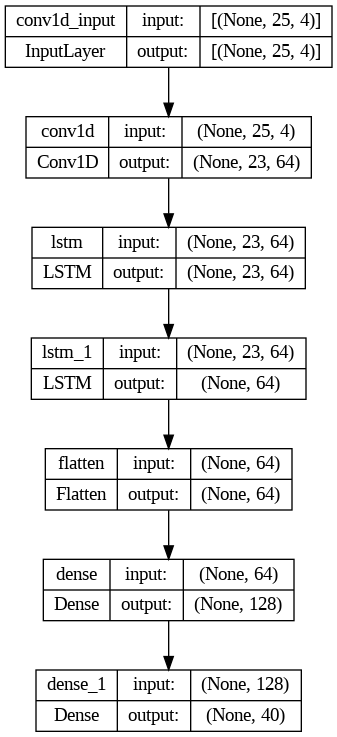

In [ ]:
from tensorflow.keras.utils  import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns=label_encoder.classes_, index=label_encoder.classes_)

<Axes: >

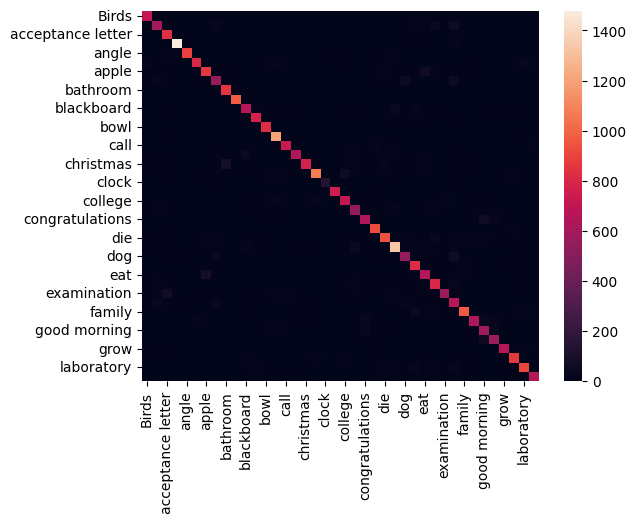

In [ ]:
sns.heatmap(cm_df)

In [ ]:
import cv2
import numpy as np
def process_and_predict (video_path):
    mp_pose = mp.solutions.pose
    # mp_drawing = mp.solutions.drawing_utils
    predictions = []
    Pose = mp_pose.Pose (
        static_image_mode=False,
        model_complexity=2,
        min_detection_confidence=0.5)

    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            break
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        results = Pose.process(image)
        image.flags.writeable = True
        try:
            pose = []
            for i, landmark in enumerate(results.pose_landmarks.landmark):
                pose.append([i, landmark.x, landmark.y, landmark.z])
            pose = np.array([pose[:25]])
            pose = pad_sequences(pose, padding='post', dtype='float', truncating='post')
            prediction = new_model.predict(pose)
            print(prediction)
            class_pred = np.argmax(prediction)
            predictions.append(class_pred)
        except Exception as e:
            print(e)
            pose = None
        # if results.pose_landmarks:
        #     mp_drawing.draw_landmarks(
        #         image,
        #         results.pose_landmarks,
        #         mp_pose.POSE_CONNECTIONS,
        #         mp.solutions.drawing_styles.get_default_pose_landmarks_style(),
        #     )
        # cv2.imshow('MediaPipe Pose', image)
        # if cv2.waitKey(5) & 0xFF == 27:
        #     break
    cap.release()
    cv2.destroyAllWindows()
    return predictions

In [ ]:
import cv2
import numpy as np

def process_and_predict(video_path):
    mp_pose = mp.solutions.pose
    predictions = []

    # Initialize Pose model
    Pose = mp_pose.Pose(
        static_image_mode=False,
        model_complexity=2,
        min_detection_confidence=0.5
    )

    # Open video capture
    cap = cv2.VideoCapture(video_path)

    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            break

        # Convert image to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Process pose estimation
        results = Pose.process(image)
        image.flags.writeable = True

        try:
            # Extract pose landmarks
            pose = []
            for i, landmark in enumerate(results.pose_landmarks.landmark):
                pose.append([i, landmark.x, landmark.y, landmark.z])
            pose = np.array([pose[:25]])

            # Pad and preprocess pose data
            pose = pad_sequences(pose, padding='post', dtype='float', truncating='post')

            # Predict class probabilities
            prediction = new_model.predict(pose)

            # Get predicted class and confidence score
            class_pred = np.argmax(prediction)
            confidence_score = np.max(prediction)

            # Append prediction and confidence score
            predictions.append((class_pred, confidence_score))
        except Exception as e:
            print(e)
            pose = None

    # Release video capture and destroy windows
    cap.release()
    cv2.destroyAllWindows()

    return predictions

In [ ]:
import mediapipe as mp
coords = mp.solutions.pose
mp_pose = coords.Pose(
    static_image_mode=False,
    model_complexity=2,
    min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.1 MB/s eta 0:00:00


In [ ]:
from tensorflow_addons.metrics import MultiLabelConfusionMatrix
import tensorflow as tf
from tensorflow.keras.utils import custom_object_scope

with custom_object_scope({'MultiLabelConfusionMatrix': MultiLabelConfusionMatrix}):
    new_model = tf.keras.models.load_model("/content/drive/MyDrive/Dataset/trained_40_88_25c.h5")

ModuleNotFoundError: No module named 'tensorflow_addons'

In [ ]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 23, 64)            832       
                                                                 
 lstm (LSTM)                 (None, 23, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 26)                3354      
                                                                 
Total params: 78554 (306.85 KB)
Trainable params: 78554 

In [ ]:
video_path = "/content/video.mp4"

In [ ]:
predictions = process_and_predict(video_path)

1/1 [==============================] - 0s 24ms/step
Ignoring empty camera frame.


In [ ]:
predictions

[(22, 0.95278233),
 (22, 0.9373287),
 (22, 0.9414676),
 (22, 0.90229493),
 (22, 0.66351414),
 (22, 0.55873406),
 (22, 0.6117168),
 (22, 0.57953763),
 (22, 0.53567195),
 (22, 0.64839625),
 (22, 0.77978265),
 (22, 0.7681443),
 (22, 0.8868293),
 (22, 0.9336528),
 (22, 0.96772724),
 (22, 0.98171943),
 (22, 0.96682525),
 (22, 0.9681305),
 (22, 0.987015),
 (22, 0.9952081),
 (22, 0.9946714),
 (22, 0.99157614),
 (22, 0.9887001),
 (22, 0.9883057),
 (22, 0.9883569),
 (22, 0.9891529),
 (22, 0.99073714),
 (22, 0.9915765),
 (22, 0.99148494),
 (22, 0.99211556),
 (22, 0.9963792),
 (22, 0.9966518),
 (22, 0.99324185),
 (22, 0.98650557),
 (22, 0.9934853),
 (22, 0.99560463),
 (22, 0.99682826),
 (22, 0.9955153),
 (22, 0.9980818),
 (22, 0.9980513),
 (22, 0.9978277),
 (22, 0.9967525),
 (22, 0.9965243),
 (22, 0.9956937),
 (22, 0.99105644),
 (22, 0.99033886),
 (22, 0.99482757),
 (22, 0.99375457),
 (22, 0.99467444),
 (22, 0.99741507),
 (22, 0.99763846),
 (22, 0.9865768),
 (22, 0.9817842),
 (22, 0.9881224),
 (2

In [ ]:
for number in predictions:
  print(number, end=" ")

1 1 1 1 1 1 12 17 17 12 19 12 19 19 19 19 19 19 12 12 12 12 19 19 19 19 4 4 4 4 4 12 12 12 12 4 4 1 1 1 1 1 1 1 1 1 1 12 12 12 12 1 1 20 20 20 20 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 17 17 17 17 17 17 4 4 4 5 5 5 5 5 4 4 5 5 5 5 5 5 5 13 5 17 17 17 17 17 17 17 12 12 12 1 1 1 1 1 1 1 1 1 1 20 20 20 1 20 20 20 20 20 20 20 20 20 20 20 1 21 21 21 12 12 12 21 21 21 5 21 5 5 5 5 21 21 21 21 21 21 21 

In [ ]:
from collections import Counter
counts = Counter(predictions)
counts

Counter({1: 45, 12: 21, 17: 15, 19: 11, 4: 12, 20: 18, 5: 18, 13: 1, 21: 14})

In [ ]:
from scipy import stats
final_prediction = stats.mode(predictions)
word = label_encoder.inverse_transform([20])

In [ ]:
word

array(['evening'], dtype=object)

In [ ]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 31, 64)            832       
                                                                 
 lstm (LSTM)                 (None, 31, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 21)                2709      
                                                                 
Total params: 77909 (304.33 KB)
Trainable params: 77909 